# **Credit Card Fraud Classification with Deep Learning (PyTorch)**

## **1- Data Preprocessing**

### 1.1-Importing Libraries

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix

import torch
from torch.nn import ReLU, Linear, BatchNorm1d, Dropout, Sequential, Module, BCEWithLogitsLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./card_transdata.csv
./credit-card-fraud-classification-with-pytorch.ipynb


### 1.2- Improting Dataset

In [5]:
dataset = pd.read_csv('./card_transdata.csv')
dataset = dataset.dropna()
dataset.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


<Axes: xlabel='fraud', ylabel='count'>

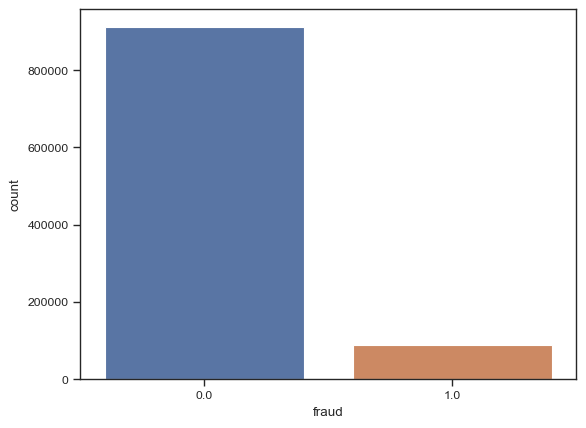

In [7]:
sns.set_context('paper', font_scale = 1)
sns.set_style('ticks')
sns.countplot(x ='fraud', data = dataset, palette ='deep')

`As it indicates, dataset is utterly imbalanced`

We choose all columns as our matrix of features except the last one, which is 'y' column.

In [8]:
real = dataset[dataset["fraud"]==0]
fraud = dataset[dataset["fraud"]==1]

real_resample = real.sample(n=87403, random_state=42) #87403
fraud_resample = fraud.sample(n = 87403, random_state=42) #87403

dataset = pd.concat([real_resample, fraud_resample], axis = 0)

In [9]:
X = dataset.iloc[:, : -1].values
y = dataset.iloc[:, -1].values

In [10]:
dataset.fraud.value_counts()
print('Shape of X:', np.shape(X))
print('Shape of y:', np.shape(y))

Shape of X: (174806, 7)
Shape of y: (174806,)


fraud
0.0    87403
1.0    87403
Name: count, dtype: int64

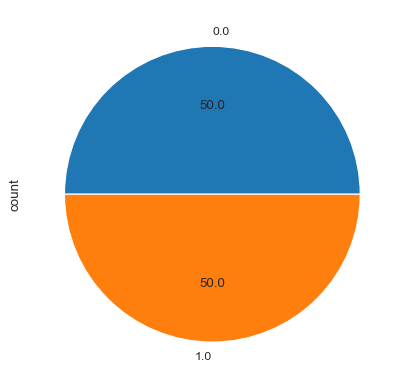

In [11]:
dataset.value_counts("fraud").plot.pie(autopct = "%.1f")
dataset.value_counts("fraud")

### 1.3- Oversampling and Train, Test split

In [12]:
#X, y = SMOTE().fit_resample(X, y)
print('Shape of X:', np.shape(X))
print('Shape of y:', np.shape(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('\nX_train:', np.shape(X_train))
print('y_train:', np.shape(y_train))
print('X_test:', np.shape(X_test))
print('y_test:', np.shape(y_test))

Shape of X: (174806, 7)
Shape of y: (174806,)

X_train: (139844, 7)
y_train: (139844,)
X_test: (34962, 7)
y_test: (34962,)


## **2- Binary Classification**

In [13]:
def plt_acc_loss(train, epochs, plttype):
    epochstoplot = range(1, epochs + 1)
    plt.plot(epochstoplot, train, label='Training ' + plttype)
    plt.title('Training ' + plttype)
    plt.xlabel('Epochs')
    plt.ylabel(plttype)
    plt.legend()
    plt.show()

### 2.1- Deep Learning

`Time to define Hyperparameters`

In [14]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.00146
WORKERS = 0
WD = 1e-6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
print('Device:', device)

Device: cuda


In [15]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TestData(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
test_loader = DataLoader(dataset=test_data, batch_size=16, shuffle=True, num_workers=WORKERS)

### 2.2- Neural Network with 3 different layers

In [16]:
class NeuralNet(Module):

    def __init__(self):
        super(NeuralNet, self).__init__()

        # Number of input features is 7.
        self.layer_1 = Linear(7, 64) 
        self.layer_2 = Linear(64, 64)
        self.layer_out = Linear(64, 1) 

        self.relu = ReLU()
        self.dropout = Dropout(p=0.1)
        self.batchnorm1 = BatchNorm1d(64)
        self.batchnorm2 = BatchNorm1d(64)
          
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [17]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

### 2.3- Training

In [18]:
start_time = time.time()

accuracy_stats = []
loss_stats = []

model = NeuralNet()
model.to(device)
loss = BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WD)

model.train()

for i in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        l = loss(y_pred, y_batch.unsqueeze(1))
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))

        epoch_loss += l.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {i:02d} / {EPOCHS:02d}: | Loss: {epoch_loss/len(train_loader):.4f} | Acc: {epoch_acc/len(train_loader):.3f}')
    loss_stats.append(epoch_loss / len(train_loader))
    accuracy_stats.append(epoch_acc / len(train_loader))


print('\nTraining is completed!')
print('_____________________________')
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

Epoch 01 / 100: | Loss: 0.2834 | Acc: 90.587
Epoch 02 / 100: | Loss: 0.2264 | Acc: 92.524
Epoch 03 / 100: | Loss: 0.2122 | Acc: 92.837
Epoch 04 / 100: | Loss: 0.1959 | Acc: 93.197
Epoch 05 / 100: | Loss: 0.1840 | Acc: 93.406
Epoch 06 / 100: | Loss: 0.1724 | Acc: 93.730
Epoch 07 / 100: | Loss: 0.1639 | Acc: 93.964
Epoch 08 / 100: | Loss: 0.1598 | Acc: 94.032
Epoch 09 / 100: | Loss: 0.1502 | Acc: 94.430
Epoch 10 / 100: | Loss: 0.1534 | Acc: 94.209
Epoch 11 / 100: | Loss: 0.1554 | Acc: 94.161
Epoch 12 / 100: | Loss: 0.1391 | Acc: 94.754
Epoch 13 / 100: | Loss: 0.1373 | Acc: 94.866
Epoch 14 / 100: | Loss: 0.1278 | Acc: 95.175
Epoch 15 / 100: | Loss: 0.1264 | Acc: 95.199
Epoch 16 / 100: | Loss: 0.1285 | Acc: 95.038
Epoch 17 / 100: | Loss: 0.1173 | Acc: 95.530
Epoch 18 / 100: | Loss: 0.1223 | Acc: 95.373
Epoch 19 / 100: | Loss: 0.1252 | Acc: 95.228
Epoch 20 / 100: | Loss: 0.1203 | Acc: 95.411
Epoch 21 / 100: | Loss: 0.1227 | Acc: 95.309
Epoch 22 / 100: | Loss: 0.1228 | Acc: 95.321
Epoch 23 /

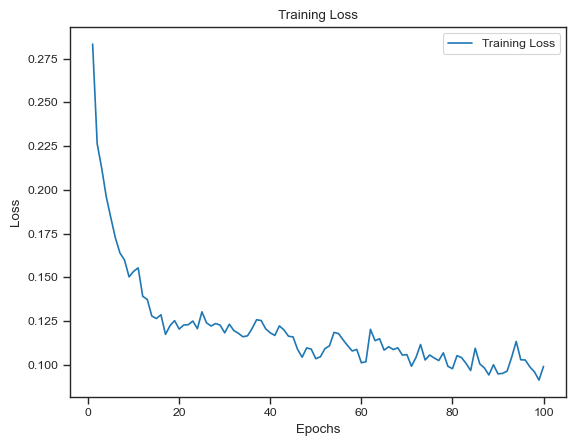

In [19]:
plt_acc_loss(loss_stats, EPOCHS, 'Loss')

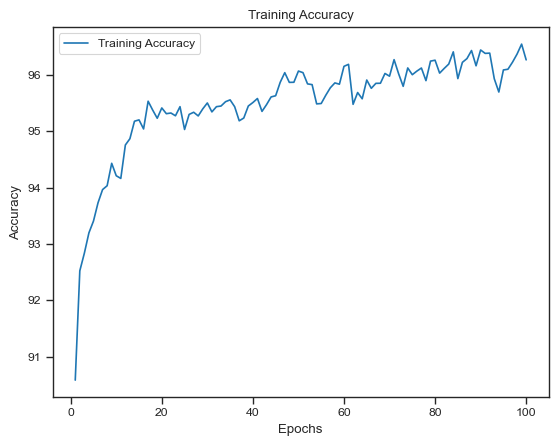

In [20]:
plt_acc_loss(accuracy_stats, EPOCHS, 'Accuracy')

### 2.4- Testing

In [21]:
start_time = time.time()

y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch_t, y_batch_t = X_batch.to(device), y_batch.to(device)
        y_test_pred = model(X_batch_t)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch_t.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

print('\Testing is completed!')
print('_____________________________')
print(f'Total Testing Time: {(time.time() - start_time)/60:.2f} min')

\Testing is completed!
_____________________________
Total Testing Time: 0.04 min


## **3- Classification Report**

In [22]:
print('CLASSIFICATION REPORTS\n')
print(classification_report(y_true_list, y_pred_list))
print('\nCONFUSION MATRIX\n')
print(confusion_matrix(y_true_list, y_pred_list))

print(f'\nMEAN SQUARE ERROR: {mean_squared_error(y_true_list, y_pred_list) :.3f}')

CLASSIFICATION REPORTS

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      1110
         1.0       0.93      1.00      0.96      1076

    accuracy                           0.96      2186
   macro avg       0.96      0.96      0.96      2186
weighted avg       0.97      0.96      0.96      2186


CONFUSION MATRIX

[[1033   77]
 [   4 1072]]

MEAN SQUARE ERROR: 0.037


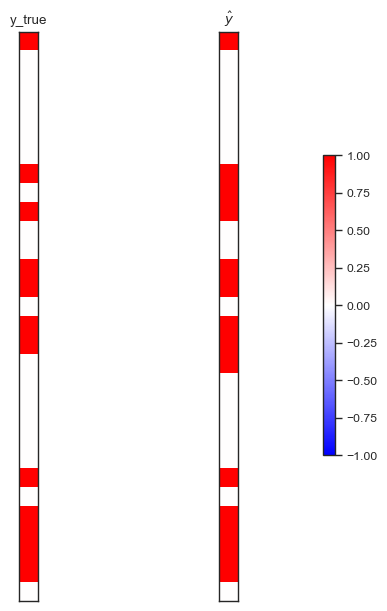

In [23]:
tensor_dict = {
    'y_true': torch.FloatTensor(y_true_list[: 30]),
    '$\hat{y}$': torch.FloatTensor(y_pred_list[: 30])
    }

n = len(tensor_dict)
vmax = max(v.abs().max() for v in tensor_dict.values())
figsize = (2 * n, 6)
fig, axes = plt.subplots(1, n, figsize=figsize, constrained_layout=True, squeeze=True)
axes = axes.flat if isinstance(axes, np.ndarray) else (axes,)
for (name, v), ax in zip(tensor_dict.items(), axes):
    v = torch.squeeze(v.detach())
    if v.ndim == 1:
        v = v.view(-1, 1)
    img = ax.matshow(v, vmin=-vmax, vmax=vmax, cmap=plt.get_cmap('bwr'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(name)
fig.colorbar(img, cax=fig.add_axes([0.985, 0.25, 0.03, .5]))